In [1]:
# Before we begin, we supress deprecation warnings resulting from nltk on Kaggle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import pandas as pd
tweets = pd.read_csv("C:/Users/pk/Desktop/projet/analyse/out_data/TweetIphone.csv")
list(tweets.columns.values)

['Unnamed: 0',
 'date',
 'text',
 'Comment',
 'Word_Tok',
 'CommentAferPreproc',
 'sentiment']

In [3]:
tweets.head()

,Unnamed: 0,date,text,Comment,Word_Tok,CommentAferPreproc,sentiment
0,0,2021-04-01 23:59:32,"b""RT @_PLICE: \xf0\x9f\xa4\xa3\xf0\x9f\xa4\xa3...","b""rt @_plice: \xf0\x9f\xa4\xa3\xf0\x9f\xa4\xa3...","['b', 'rt', '_plice', 'xf0', 'x9f', 'xa4', 'xa...",b rt _plice xf0 x9f xa4 xa3 xf0 x9f xa4 xa3 xf...,Neutral
1,1,2021-04-01 23:59:32,b'RT @twinkologian: sza the type to say she go...,b'rt @twinkologian: sza the type to say she go...,"['b', 'rt', 'twinkologian', 'sza', 'the', 'typ...",b rt twinkologian sza type say got iphone 15 x...,Neutral
2,2,2021-04-01 23:59:29,b'Check out this product from the Apple Store:...,b'check out this product from the apple store:...,"['b', 'check', 'out', 'this', 'product', 'from...",b check product apple store n nhttps co xozusg...,Neutral
3,3,2021-04-01 23:59:28,b'I\xe2\x80\x99ve had a great birthday so far!...,b'i\xe2\x80\x99ve had a great birthday so far!...,"['b', 'i', 'xe2', 'x80', 'x99ve', 'had', 'a', ...",b xe2 x80 x99ve great birthday far mom delicio...,Positive
4,4,2021-04-01 23:59:21,b'I go on vacation for the first time in well ...,b'i go on vacation for the first time in well ...,"['b', 'i', 'go', 'on', 'vacation', 'for', 'the...",b go vacation first time well year think would...,Positive


In [6]:
sentiment_counts = tweets.sentiment.value_counts()
print(sentiment_counts)

Neutral     4981
Positive    3479
Negative    1771
Name: sentiment, dtype: int64


In [7]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [8]:
vectorized_data = count_vectorizer.fit_transform(tweets.text)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [10]:
def sentiment2target(sentiment):
    return {
        'Negative': 0,
        'Neutral': 1,
        'Positive' : 2
    }[sentiment]
targets = tweets.sentiment.apply(sentiment2target)

In [11]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

# Model SVM

In [12]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

In [37]:
clf.score(data_test, targets_test)
pre=clf.predict(data_test)
acc=metrics.accuracy_score(pre, targets_test)
print(str("{:04.2f}".format(acc*100))+'%')

94.01%


# Model Naive bayes

In [34]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
mnb.fit(data_train,targets_train)
preticted=mnb.predict(data_test)
accuracy=metrics.accuracy_score(preticted, targets_test)
print(str("{:04.2f}".format(accuracy*100))+'%')

89.76%


# Model Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(data_train,targets_train)
preticted3=dt.predict(data_test)
accuracy3=metrics.accuracy_score(preticted3, targets_test)
print(str("{:04.2f}".format(accuracy3*100))+'%')

91.69%


# Model Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=40)
rf.fit(data_train,targets_train)
preticted4=rf.predict(data_test)
accuracy4=metrics.accuracy_score(preticted4, targets_test)
print(str("{:04.2f}".format(accuracy4*100))+'%')

91.13%


In [14]:
sentences = count_vectorizer.transform([
    "What a great airline, the trip was a pleasure!",
    "My issue was quickly resolved after calling customer support. Thanks!",
    "What the hell! My flight was cancelled again. This sucks!",
    "Service was awful. I'll never fly with you again.",
    "You fuckers lost my luggage. Never again!",
    "I have mixed feelings about airlines. I don't know what I think.",
    ""
])
clf.predict_proba(sentences)

array([[0.04790416, 0.71567989, 0.23641595],
       [0.13169614, 0.3951206 , 0.47318325],
       [0.13127747, 0.75188759, 0.11683494],
       [0.10335529, 0.82922565, 0.06741906],
       [0.08847515, 0.87467354, 0.03685132],
       [0.03907321, 0.91226962, 0.04865717],
       [0.02520723, 0.94355046, 0.03124231]])

In [15]:
predictions_on_test_data = clf.predict_proba(data_test)
index = np.transpose(np.array([range(0,len(predictions_on_test_data))]))
indexed_predictions = np.concatenate((predictions_on_test_data, index), axis=1).tolist()

In [16]:
def marginal(p):
    top2 = p.argsort()[::-1]
    return abs(p[top2[0]]-p[top2[1]])
margin = sorted(list(map(lambda p : [marginal(np.array(p[0:3])),p[3]], indexed_predictions)), key=lambda p : p[0])
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].text, margin[0:10]))

["b'Wow! Get this Plastic Car Charger for iPhone for only $ \\nhttps://t.co/1nffYuJExF\\n.\\n.\\nFor more visit ForteSpy Produc\\xe2\\x80\\xa6 https://t.co/tgVmTK7c5Z'",
 "b'and they either do it very low quality, glasses and hoodie on, using photobooth/iphone or use their filming equipme\\xe2\\x80\\xa6 https://t.co/91CzJQOnnL'",
 "b'@TeslaStars @iphone_robm I threw up in my mouth a little from this tweet... https://t.co/HJBZXRGPQR'",
 "b'@SUNHL28 Oh oh sorry my iPhone is little slow and it didn\\xe2\\x80\\x99t load the header, love it and still soft'",
 "b'A new unidentified dynamic portrait of #iPhone user #cyberart https://t.co/TWMRbz4eIN'",
 "b'Ain\\xe2\\x80\\x99t no difference with this iPhone 12 &amp; my iPhone 11.'",
 "b'RT @iSpyphotographs: Hello #htlmphour This is my first time here #iSpy with my little ... camera! An iPhone view of life - beaches, houses,\\xe2\\x80\\xa6'",
 "b'@bing will bing wallpaper be available on   iphone?'",
 "b'i wish i never lost my adapter to my ipho

In [17]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[0:10]))

[array([0.01028585, 0.49486333, 0.49485083]),
 array([0.0197658 , 0.48829803, 0.49193617]),
 array([0.28036641, 0.36195573, 0.35767786]),
 array([5.02719820e-01, 5.28740084e-05, 4.97227306e-01]),
 array([0.50421808, 0.00071697, 0.49506496]),
 array([0.49495698, 0.48514733, 0.01989568]),
 array([0.50305281, 0.00396434, 0.49298285]),
 array([0.00610284, 0.50305354, 0.49084362]),
 array([0.4282397 , 0.44153867, 0.13022162]),
 array([0.4282397 , 0.44153867, 0.13022162])]

In [18]:
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].text, margin[-10:]))

["b'Which recycled tweet do I hit first \\xe2\\x80\\x9cApple Music should be free if you have an iPhone\\xe2\\x80\\x9d or \\xe2\\x80\\x9cApples best tweet was th\\xe2\\x80\\xa6 https://t.co/2ehiKL5po3'",
 "b'Got a IPhone 12 at a pretty good price from my job , giving it a try . The phone feels good , i like that IOS 14 le\\xe2\\x80\\xa6 https://t.co/K96PdUoJol'",
 "b'Wow! iPhone Prank Assistant. New iOS Update 14.4.3 \\xe2\\x9d\\xa4\\xef\\xb8\\x8f @apple @mix93fm #Wow #PrankAssistant #New #BuiltIn #Download\\xe2\\x80\\xa6 https://t.co/Mg1LJ3edBM'",
 "b'RT @aboki_gadgets: Brand New iPhones\\nPrice update on brand new phones\\niPhone 11 64gb - N315,000\\niPhone 11 128gb - N340,000\\niPhone 11 Pro 64\\xe2\\x80\\xa6'",
 "b'I love the new iPhone 12 Pro Max , Enjoying it rn a lot , Thanks @YouTube for the money \\xe2\\x9d\\xa4\\xef\\xb8\\x8f'",
 "b'RT @Phone_Stores: Please Dont Skip Without Retweeting \\xf0\\x9f\\x99\\x8f\\xf0\\x9f\\x99\\x8f\\n\\nBRAND NEW IPHONE XS max 270k\\nBRAND NEW IPHO

In [19]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[-10:]))

[array([1.31470472e-03, 1.35164321e-04, 9.98550131e-01]),
 array([8.62808406e-04, 4.94821180e-04, 9.98642370e-01]),
 array([9.39236525e-04, 1.51706386e-04, 9.98909057e-01]),
 array([3.18177657e-04, 7.43768307e-04, 9.98938054e-01]),
 array([6.20935117e-04, 1.19813453e-05, 9.99367084e-01]),
 array([2.11415808e-04, 3.64289611e-07, 9.99788220e-01]),
 array([2.11415808e-04, 3.64289611e-07, 9.99788220e-01]),
 array([2.11415808e-04, 3.64289611e-07, 9.99788220e-01]),
 array([6.22123292e-05, 2.52786851e-06, 9.99935260e-01]),
 array([9.99995918e-08, 9.99995818e-01, 4.08184366e-06])]

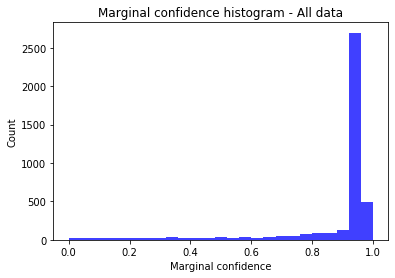

In [24]:
import matplotlib.pyplot as plt
marginal_probs = list(map(lambda p : p[0], margin))
n, bins, patches = plt.hist(marginal_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - All data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

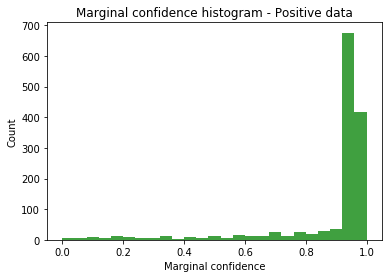

In [21]:
positive_test_data = list(filter(lambda row : row[0]==2, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='green', alpha=0.75)
plt.title('Marginal confidence histogram - Positive data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

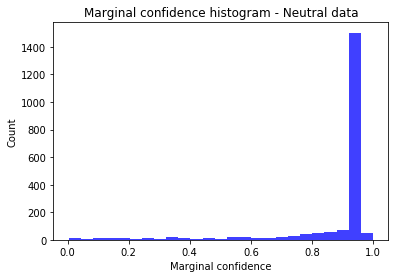

In [22]:
positive_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - Neutral data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

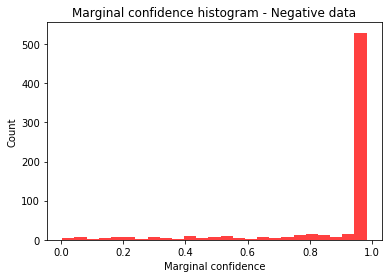

In [23]:
negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))
negative_probs = clf.predict_proba(list(map(lambda r : r[1:], negative_test_data)))
marginal_negative_probs = list(map(lambda p : marginal(p), negative_probs))
n, bins, patches = plt.hist(marginal_negative_probs, 25, facecolor='red', alpha=0.75)
plt.title('Marginal confidence histogram - Negative data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()